In [23]:
import os
import torch
from torchtools.utils import plot_batch

from train_autoprotonet import get_dataset, get_model
from vis_prototypes import get_prototypes, get_support_query_data_labels_model, generate_prototype_img_using_adam

In [33]:
ckpt_dir = '/vulcanscratch/psando/checkpoints-meta/workshop_paper_checkpoints/imagenet_pretrained_2'
dataset = 'CIFAR_FS' # 'miniImageNet' # 'CIFAR_FS'

test_way = 5
val_shot = 5
val_query = 5
val_episode = 2000
episodes_per_batch = 1

class Options(object):
    def __init__(self, dataset, network, test_way, val_shot, val_query, head='ProtoNet'):
        self.dataset = dataset
        self.network = network
        self.head = head
        self.activation = 'LeakyReLU'
        self.test_way = test_way
        self.val_shot = val_shot
        self.val_query = val_query
        self.episodes_per_batch = episodes_per_batch
opt = Options(dataset=dataset, network='AutoProtoNet', test_way=test_way, val_shot=val_shot, val_query=val_query)

In [34]:
data_support, labels_support, data_query, labels_query, embedding_net, cls_head = get_support_query_data_labels_model(opt, epoch=2)

Loading CIFAR-FS dataset - phase train
Loading CIFAR-FS dataset - phase val


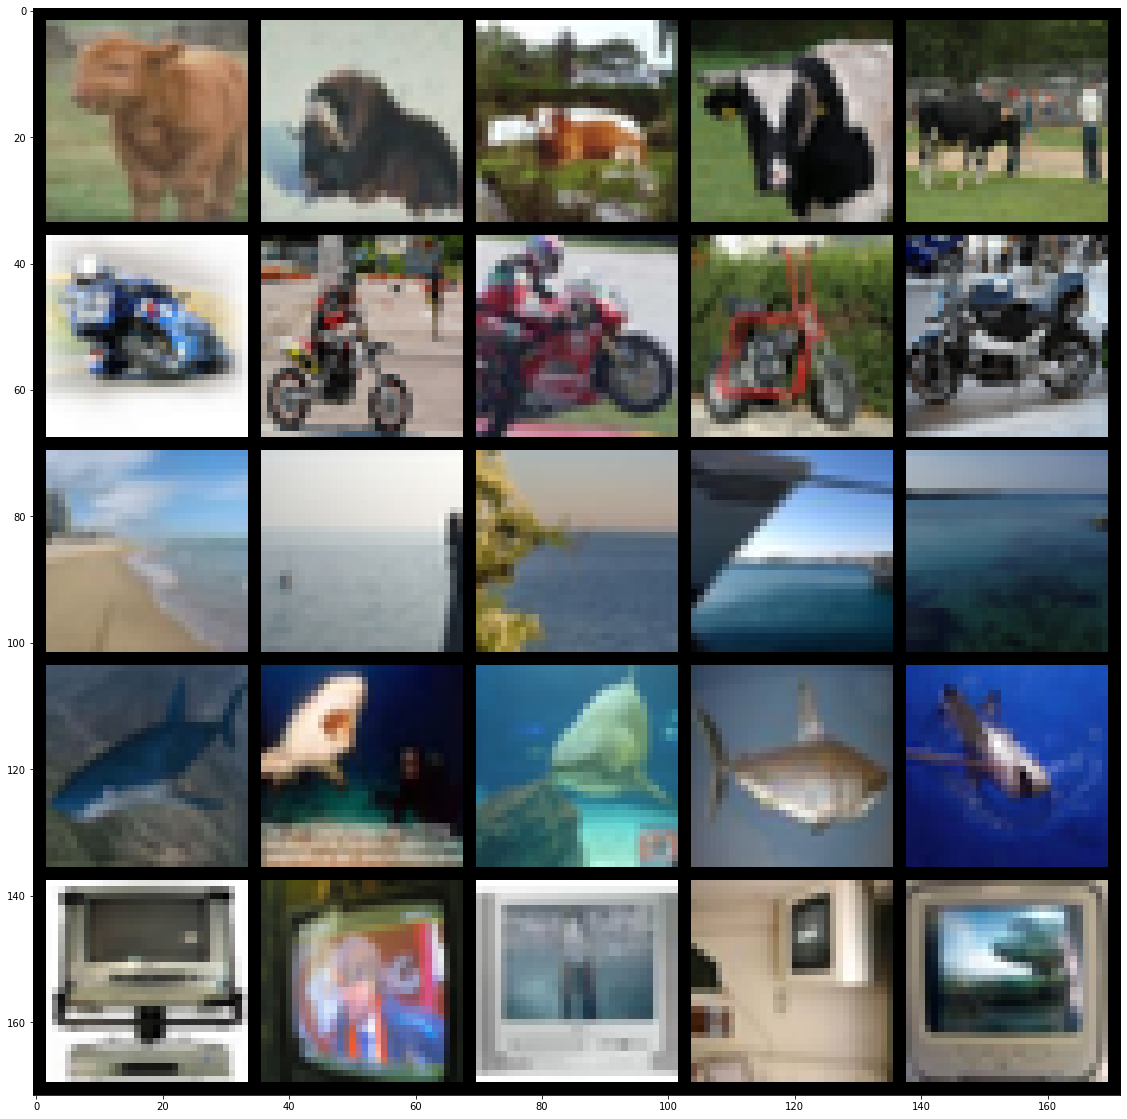

In [35]:
labels_support = labels_support.squeeze()
sort_support_indices = torch.argsort(labels_support)
plot_batch(data_support[sort_support_indices].cpu(), figsize=(20,20), nrow=test_way)

In [36]:
ckpt = torch.load(os.path.join(ckpt_dir, 'best_model.pth'))
embedding_net.load_state_dict(ckpt['embedding'], strict=True)

<All keys matched successfully>

In [37]:
with torch.no_grad():
    emb_query = embedding_net(data_query)
    emb_support = embedding_net(data_support)
    print('emb query shape', emb_query.shape)
    print('emb support shape', emb_support.shape)
    train_n_support = test_way * val_shot
    train_n_query = test_way * val_query
    emb_query = emb_query.reshape(episodes_per_batch, train_n_query, -1)
    emb_support = emb_support.reshape(episodes_per_batch, train_n_support, -1)
    print('emb query shape reshaped', emb_query.shape)
    print('emb support shape reshaped', emb_support.shape)
    prototypes = get_prototypes(emb_query, emb_support, labels_support, test_way, val_shot)
    print('prototypes shape', prototypes.shape)

emb query shape torch.Size([25, 256])
emb support shape torch.Size([25, 256])
emb query shape reshaped torch.Size([1, 25, 256])
emb support shape reshaped torch.Size([1, 25, 256])
prototypes shape torch.Size([1, 5, 256])


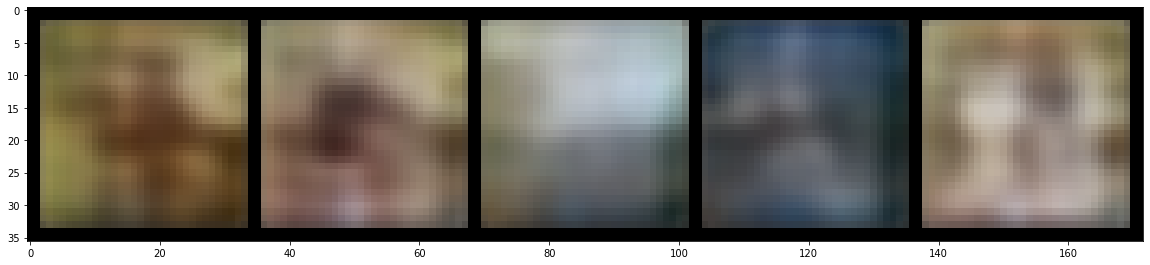

In [38]:
# Plot decoder reconstructions of prototypes
plot_batch(embedding_net.forward_decoder(prototypes.reshape(embedding_net.embedding_shape)).cpu(), figsize=(20,20))

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


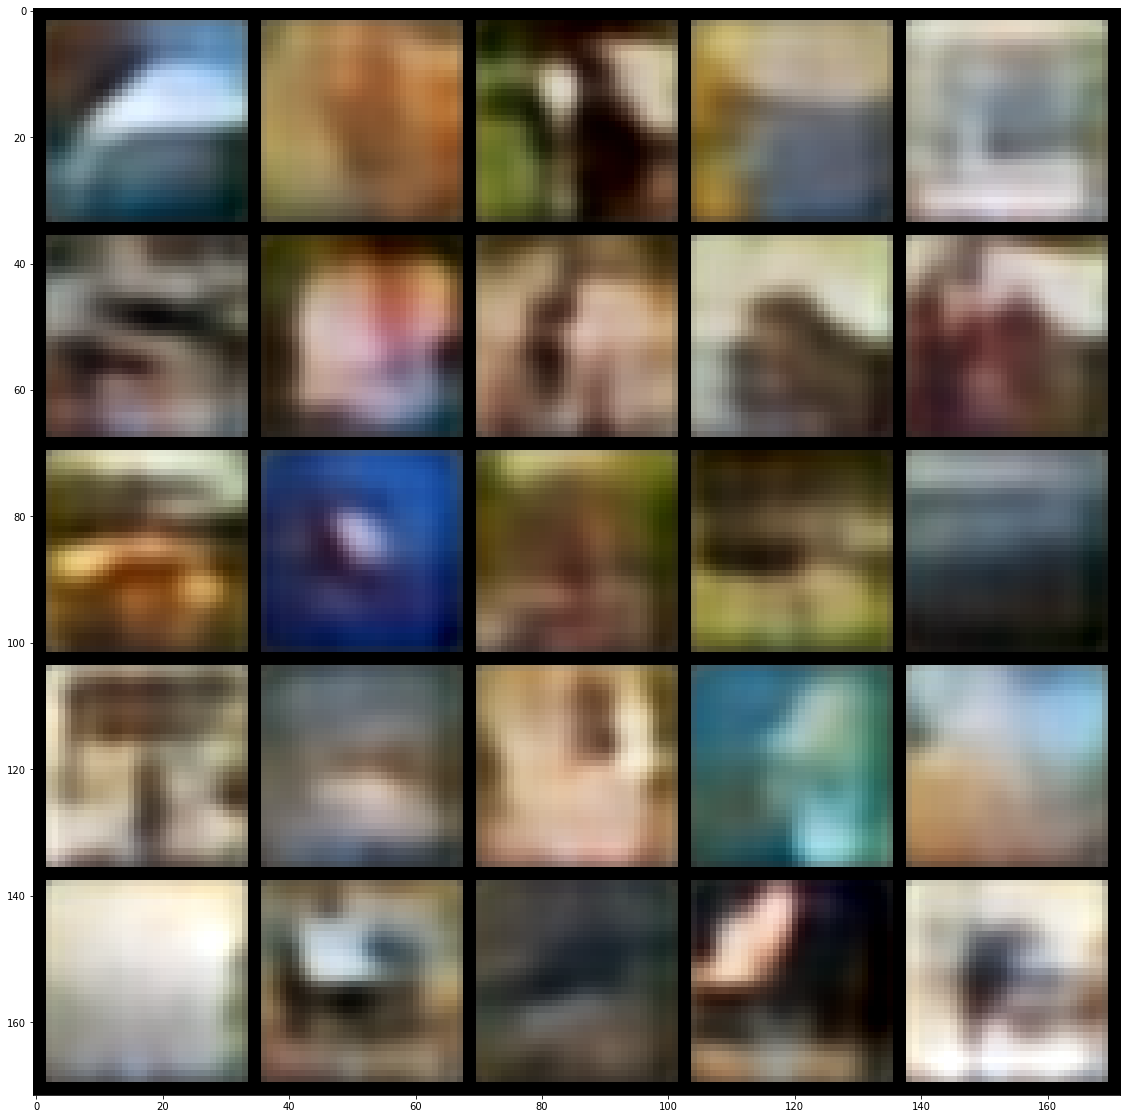

In [39]:
# Plot decoder reconstructions of support data
plot_batch(embedding_net.forward_decoder(emb_support.reshape(embedding_net.embedding_shape)).cpu(), figsize=(20,20), nrow=val_shot)

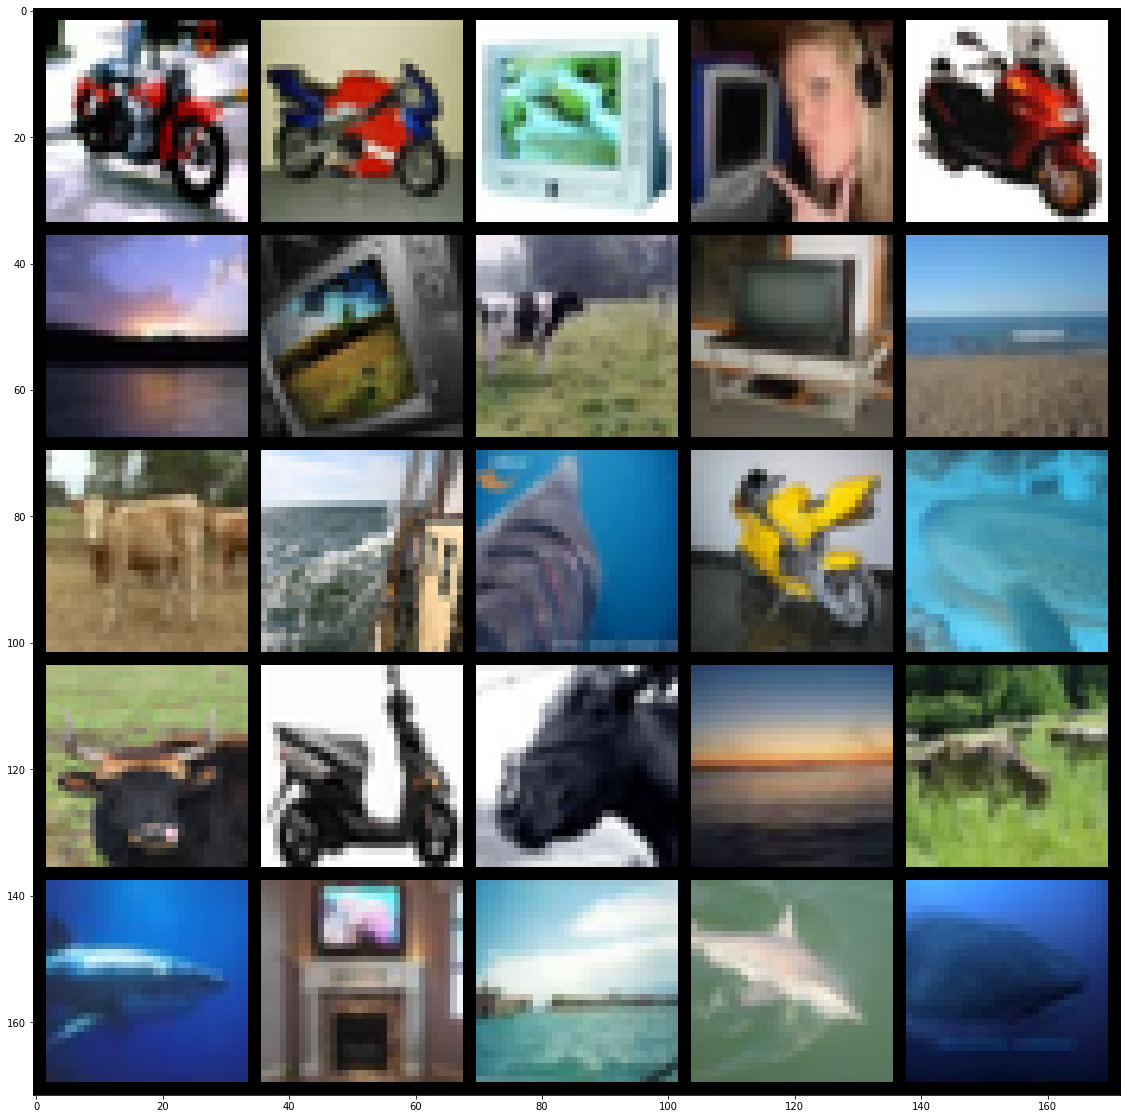

In [40]:
# Plot query data
plot_batch(data_query.cpu(), figsize=(20,20), nrow=val_shot)

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


Predictions: tensor([0, 1, 4, 0, 4, 2, 1, 1, 0, 1, 2, 2, 2, 2, 3, 3, 3, 2, 2, 3, 0, 0, 4, 3,
        0], device='cuda:0')
Labels     : tensor([0, 0, 0, 0, 0, 1, 1, 1, 1, 1, 2, 2, 2, 2, 2, 3, 3, 3, 3, 3, 4, 4, 4, 4,
        4], device='cuda:0')
Accuracy   : 52.00%


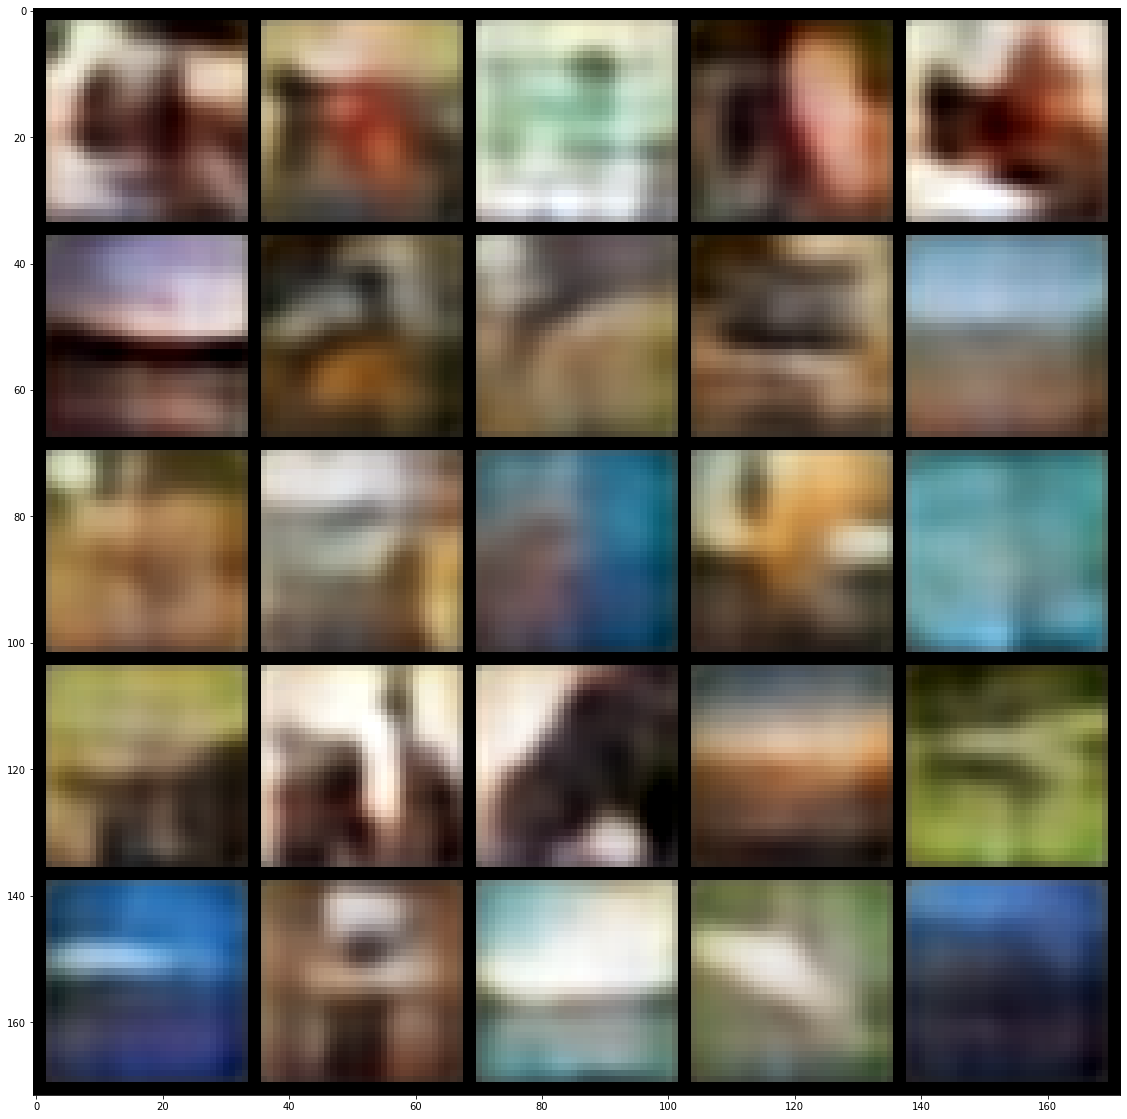

In [41]:
from utils import count_accuracy
# Plot decoder reconstructions of query data
# Sort query data
labels_query = labels_query.squeeze()
sort_query_indices = torch.argsort(labels_query)

# Produce logits
logits = cls_head(emb_query.squeeze(dim=0)[sort_query_indices].unsqueeze(dim=0), emb_support, labels_support, test_way, val_shot)
pred = torch.argmax(logits.reshape(-1, test_way), dim=1).view(-1)
sorted_labels_query = labels_query[sort_query_indices].reshape(-1)
acc = count_accuracy(logits.reshape(-1, test_way), sorted_labels_query.reshape(-1))
print('Predictions:', pred)
print('Labels     :', sorted_labels_query)
print('Accuracy   : {:.2f}%'.format(acc.item()))

plot_batch(embedding_net.forward_decoder(emb_query.reshape(embedding_net.embedding_shape)).cpu(), figsize=(20,20), nrow=val_shot)